# Multi-Image Panorama Creation



## Why?

Sometimes the scenes what you want to capture are much larger than the camera you have.

What we can do in this case is capture multiple images and stitch them together to form one large image (of the entire scene).


Such photos of ordered scenes of collections are called panoramas. The entire process of acquiring multiple image and converting them into such panoramas is called as image stitching

## How?

Creating such panoramas involves the following steps:

1.  Estimate [homography](https://docs.opencv.org/3.4.1/d9/dab/tutorial_homography.html)

  1. Compute the sift-key points and descriptors (feature extraction)
  2. Select the top best matches for each descriptor of an image.
  3. Match correspondence between descriptors of the images
  4. Use these matched points with [RANSAC](https://www.mathworks.com/discovery/ransac.html) to compute [homography](https://docs.opencv.org/3.4.1/d9/dab/tutorial_homography.html)

2.  Image-Warping
  1. Use the homography calculated to align the images properly

3. Stitch the images
  1. Stitch the aligned images
  1. Do any cleaning if needed (eg. trim)


## Code

### Step 0: Load the images

In [0]:
!pip install opencv-contrib-python==3.4.2.16

In [0]:
import cv2
import numpy as np

img_left = cv2.imread('original_image_left.jpg')
img_left = cv2.resize(img_left, (0,0), fx=1, fy=1)
img1 = cv2.cvtColor(img_left,cv2.COLOR_BGR2GRAY)

img_right = cv2.imread('original_image_right.jpg')
img_right = cv2.resize(img_right, (0,0), fx=1, fy=1)
img2 = cv2.cvtColor(img_right,cv2.COLOR_BGR2GRAY)

### Step 1: Homography


#### Compute SIFT

We can find the SIFT descriptors using `opencv_contrib's SIFT descriptor`

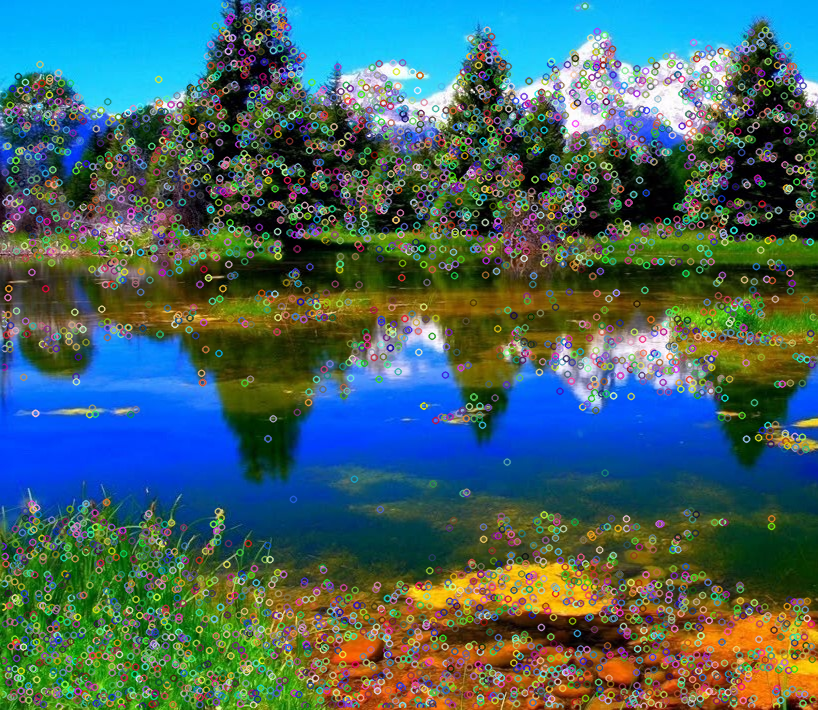

In [0]:
from google.colab.patches import cv2_imshow

sift = cv2.xfeatures2d.SIFT_create()
# find the key points and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

cv2_imshow(cv2.drawKeypoints(img_left,kp1,None))

#### Find matching descriptors

In order to join any two images into a bigger image, we must find overlapping points. These overlapping points will give us an idea of the orientation of the second image according to first one.

Some features might be existing in multiple places. So we filter out through all the matches to obtain the best ones using a ratio test (I have used 0.4)

We can use `BFMatcher` from opencv for the same

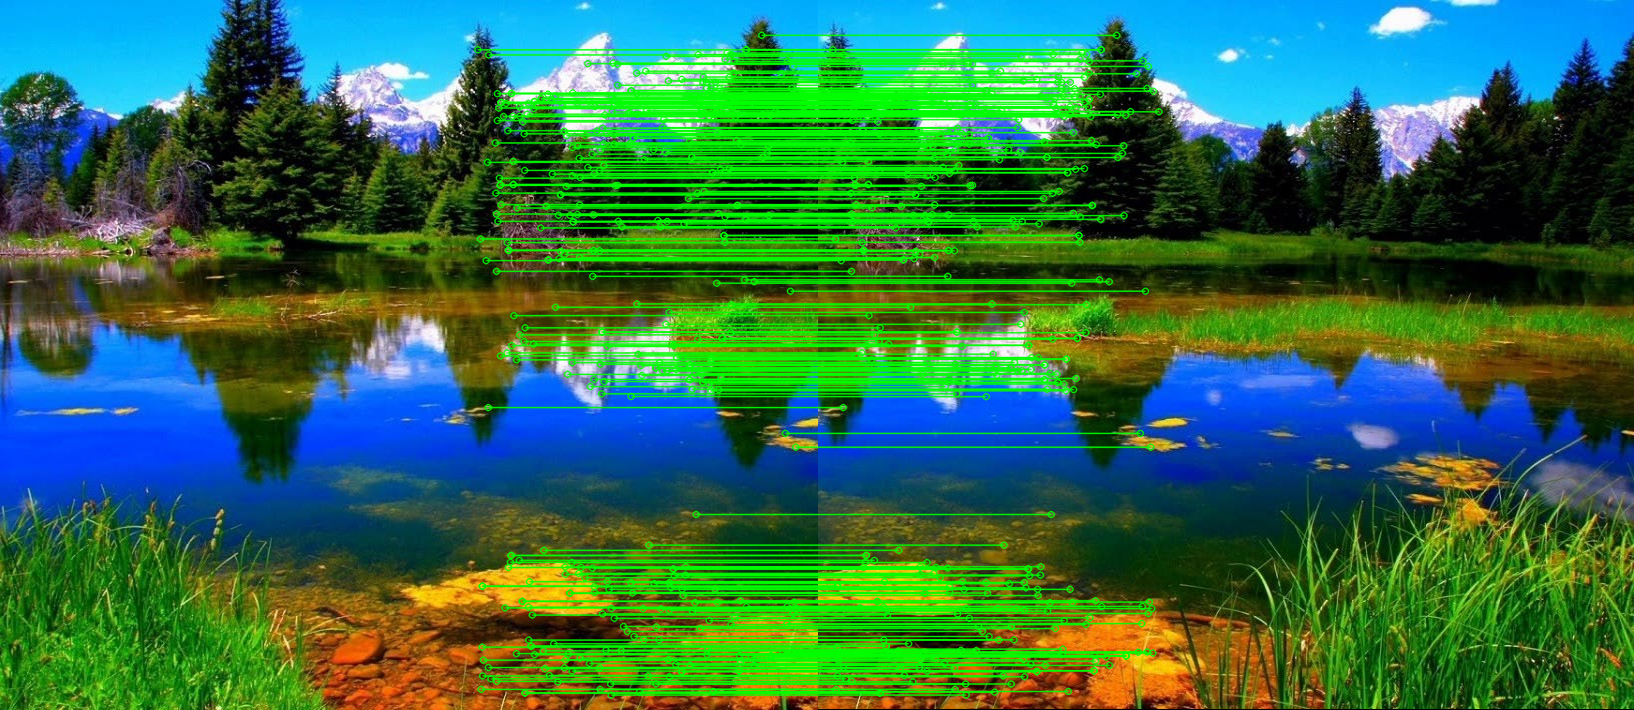

In [0]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

best = []
for m,n in matches:
  if m.distance / n.distance < 0.04:
    best.append(m)
    
    
draw_params = dict(matchColor = (0,255,0), # green color
                   singlePointColor = None,
                   flags = 2)

img3 = cv2.drawMatches(img_left, kp1, img_right, kp2, best, None, **draw_params)
cv2_imshow(img3)

#### Find Homography

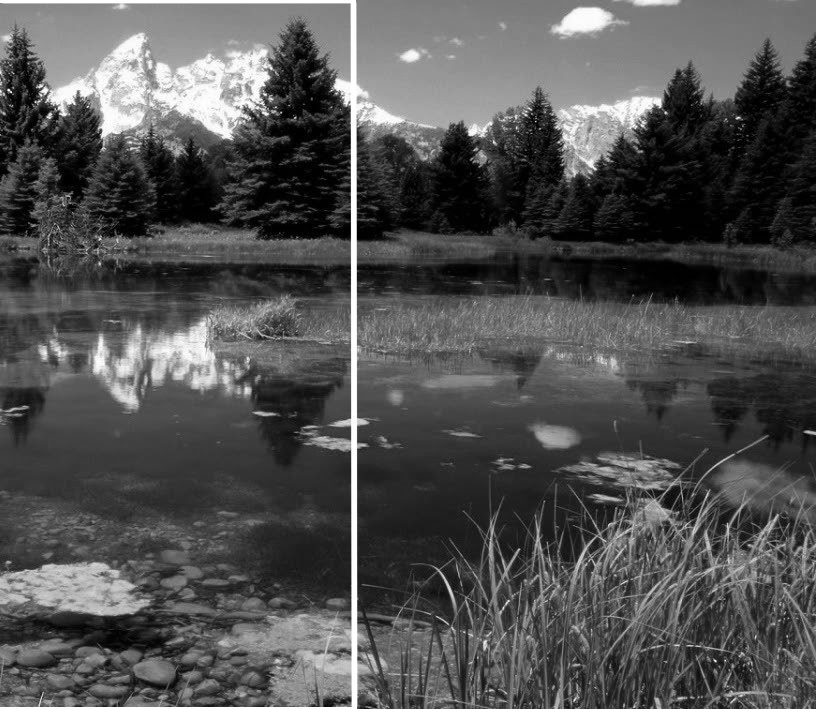

In [0]:
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

h,w = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)

img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
cv2_imshow(img2)

### Warp Image and Stitch it

In [0]:
dst = cv2.warpPerspective(img_left, M, (img_right.shape[1] + img_left.shape[1], img_right.shape[0]))
dst[0:img_right.shape[0], 0:img_right.shape[1]] = img_right	

In above code we are taking overlapping area from two given images. We have received only right side of the image which is not overlapped, so in second line of code we are placing our left side image to final image:

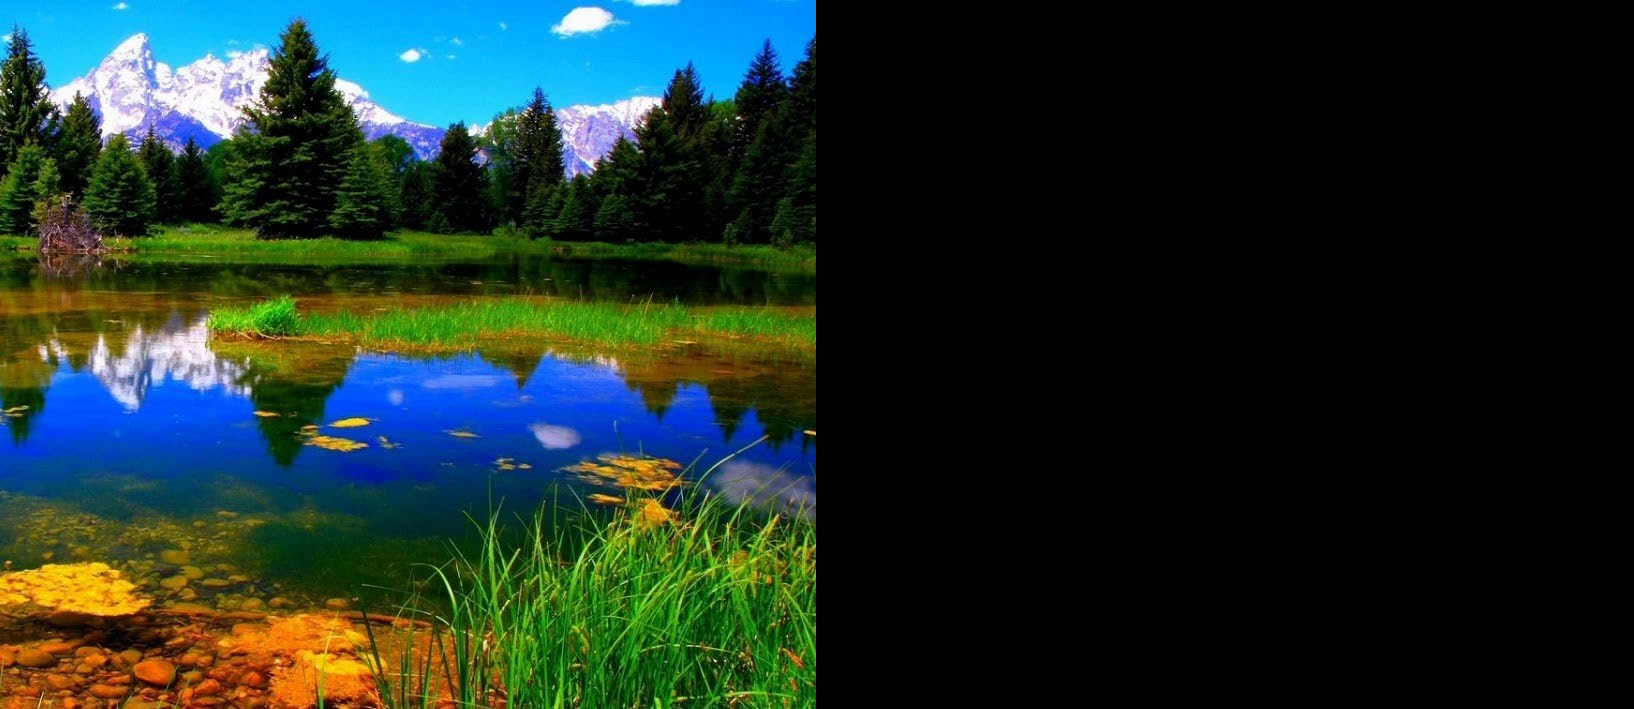

In [0]:
cv2_imshow(dst)

### Cleaning 

We need to remove the black portion of the image on the borders:

In [0]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:]) 
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])    
    return frame

dst = trim(dst)

## Result

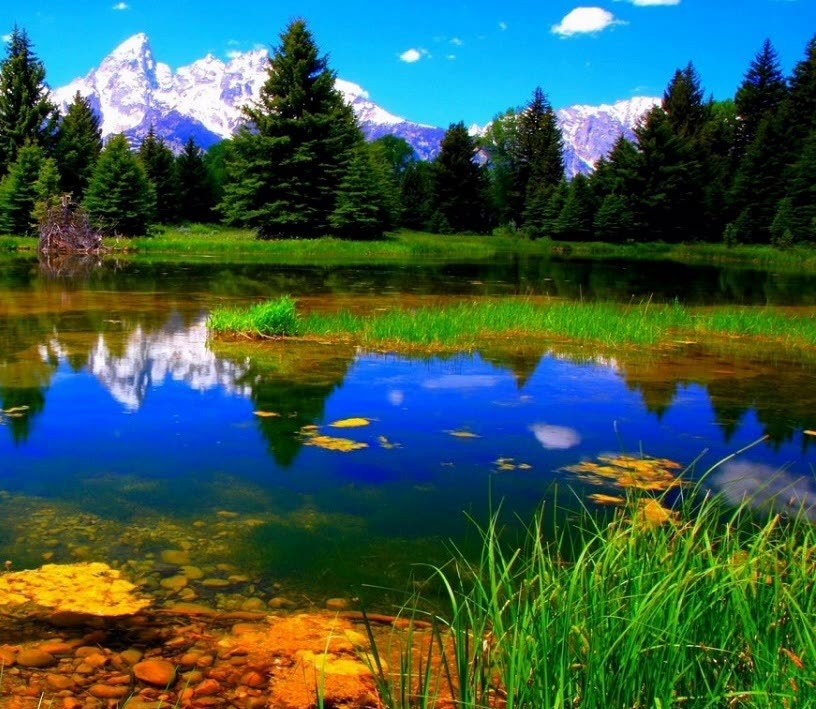

In [0]:
cv2_imshow(dst)